### Generating human faces with Adversarial Networks (5 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week08_autoencoders/lfw_dataset.py -O lfw_dataset.py

--2021-05-12 17:42:55--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week08_autoencoders/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3060 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.99K  --.-KB/s    in 0s      

2021-05-12 17:42:55 (46.1 MB/s) - ‘lfw_dataset.py’ saved [3060/3060]



In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36, dimy=36)

#preprocess faces
data = np.float32(data).transpose([0,3,1,2]) / 255.

IMG_SHAPE = data.shape[1:]

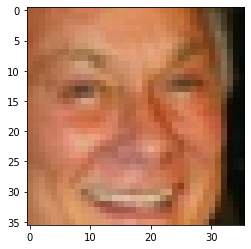

In [3]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])].transpose([1,2,0]),
           cmap="gray", interpolation="none")

In [4]:
data.shape

(13143, 3, 36, 36)

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [5]:
torch.cuda.is_available()

True

In [6]:
import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 1.8.1+cu101
Using GPU


In [7]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

In [8]:
CODE_SIZE = 256

from itertools import count
# automatic layer name maker. Don't do this in production :)
ix = ('layer_%i'%i for i in count())

generator = nn.Sequential()

generator.add_module(next(ix), nn.Linear(CODE_SIZE, 10*8*8))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), Reshape([-1, 10, 8, 8]))

generator.add_module(next(ix), nn.ConvTranspose2d(10, 64, kernel_size=(5,5)))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.ConvTranspose2d(64, 64, kernel_size=(5,5)))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.Upsample(scale_factor=2))

generator.add_module(next(ix), nn.ConvTranspose2d(64, 32, kernel_size=(5,5)))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.ConvTranspose2d(32, 32, kernel_size=(5,5)))
generator.add_module(next(ix), nn.ELU())

generator.add_module(next(ix), nn.Conv2d(32, 3, kernel_size=(5,5)))

if use_cuda: generator.cuda()

In [9]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generated_data.shape)

In [10]:
generator

Sequential(
  (layer_0): Linear(in_features=256, out_features=640, bias=True)
  (layer_1): ELU(alpha=1.0)
  (layer_2): Reshape()
  (layer_3): ConvTranspose2d(10, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer_4): ELU(alpha=1.0)
  (layer_5): ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (layer_6): ELU(alpha=1.0)
  (layer_7): Upsample(scale_factor=2.0, mode=nearest)
  (layer_8): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer_9): ELU(alpha=1.0)
  (layer_10): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (layer_11): ELU(alpha=1.0)
  (layer_12): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1))
)

In [11]:
generator(sample_noise_batch(5)).shape

torch.Size([5, 3, 36, 36])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [12]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.shape[0], -1)

In [13]:
discriminator = nn.Sequential()

### YOUR CODE - create convolutional architecture for discriminator
### Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

discriminator.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
discriminator.add_module('pool1', nn.MaxPool2d(2))
discriminator.add_module('norm1', nn.BatchNorm2d(10))

discriminator.add_module('conv2', nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3))
discriminator.add_module('pool2', nn.MaxPool2d(2))
discriminator.add_module('norm2', nn.BatchNorm2d(20))
#
discriminator.add_module('conv3', nn.Conv2d(in_channels=20, out_channels=100, kernel_size=3))
discriminator.add_module('pool3', nn.MaxPool2d(2))
discriminator.add_module('norm3', nn.BatchNorm2d(100))
#
discriminator.add_module('flatten', Flatten())
discriminator.add_module("disc_logit", nn.Linear(in_features=400, out_features=1000))
discriminator.add_module("disc_logit2", nn.Linear(in_features=1000, out_features=1))

if use_cuda: discriminator.cuda()

In [14]:
discriminator(sample_data_batch(5)).shape

torch.Size([5, 1])

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/cw4nognxx/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [15]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data) + 0.00001
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = -logp_gen_is_real.mean(axis=0)
    
    return loss

In [16]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

tensor([0.6725], device='cuda:0', grad_fn=<NegBackward>)


In [17]:
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(- disc_on_fake_data)
    
    loss = -1*(logp_real_is_real + logp_gen_is_fake)/2
    return loss.mean(axis=0)

In [18]:
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

tensor([0.7279], device='cuda:0', grad_fn=<MeanBackward1>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [19]:
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [20]:
#optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

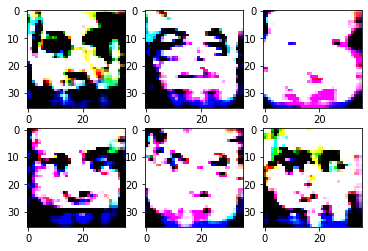

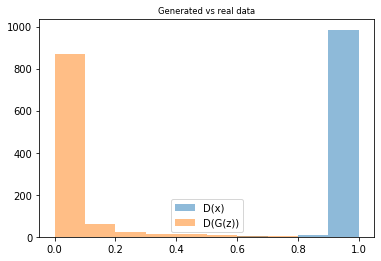

KeyboardInterrupt: ignored

In [21]:
from IPython import display
from tqdm import tnrange
batch_size = 100

for epoch in tnrange(50000):
    
    # Train discriminator
    for i in range(5):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        
    # Train generator
    noise = sample_noise_batch(batch_size)
    loss = generator_loss(noise)
    gen_opt.zero_grad()
    loss.backward()
    gen_opt.step()
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        

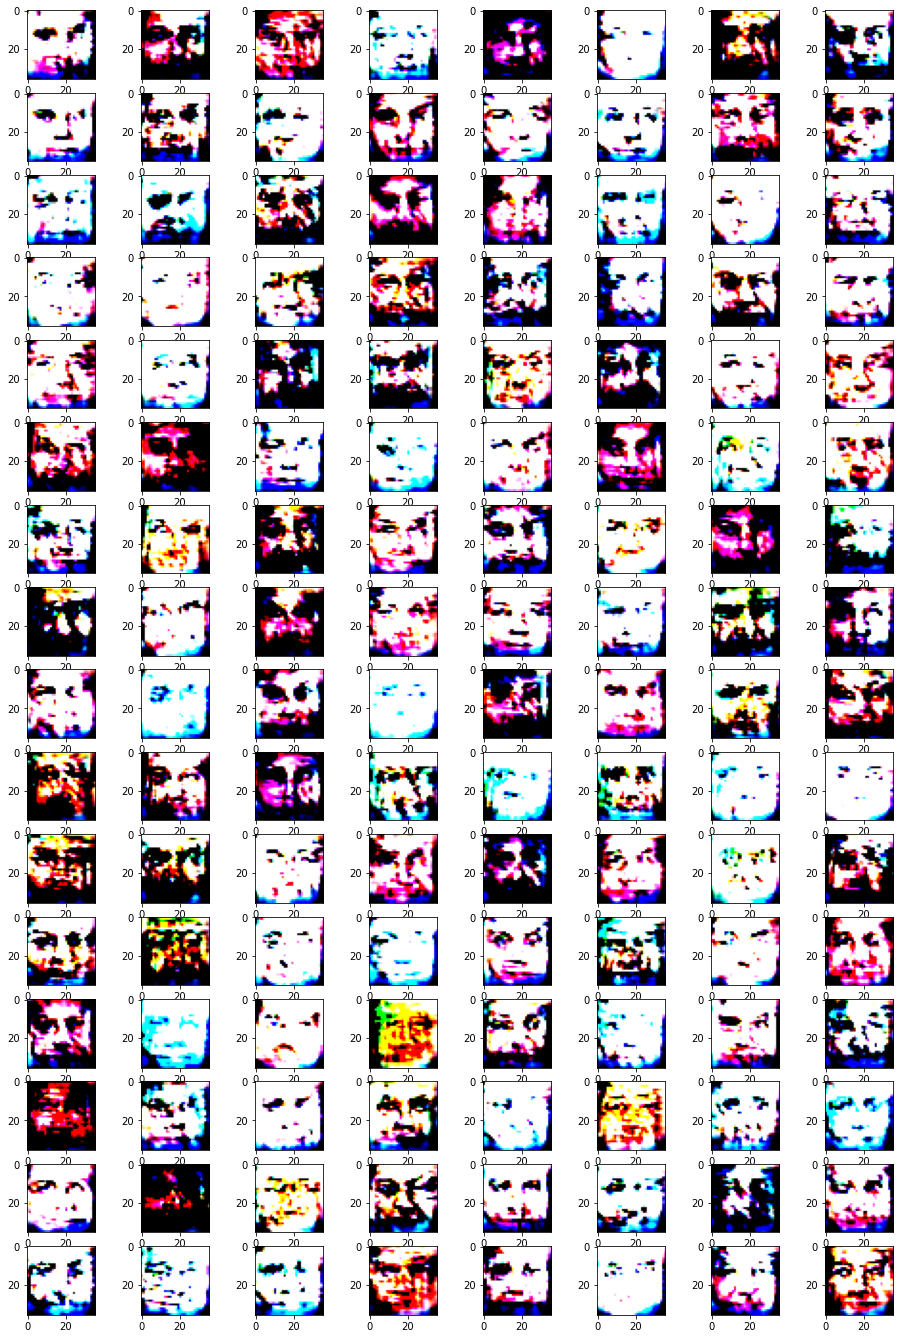

In [22]:
plt.figure(figsize=[16, 24])
sample_images(16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

### Evaluation
__The code below__ dumps a batch of images so that you could use them for precision/recall evaluation.

Please, if you want to compare the result with the autoencoder result, generate the same number of images as for autoencoders for a fair comparison.

In [ ]:
num_images = <YOUR CODE>
batch_size = 100

all_images = []

for batch_i in range((num_images - 1) / batch_size + 1):
    with torch.no_grad():
        images = generator(sample_noise_batch(batch_size=batch_size))
        images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(np.min(data), np.max(data))
        
    all_images.append(images)
    
all_images = np.concatenate(all_images, axis=0)[:num_images]

np.savez("./gan.npz", Pictures=all_images)